# Erdio: Testing Classifiers

Testing audio classifiers for Project Erdio, an urban environmental sound classifier.

Team members (no particular order): Matthew Frick, Matthew Heffernan, Paul Jredini, Jonathan Osborne, Joanne Dong  

Goal: Classify sounds for key stakeholders (see Stakeholder and KPI documentation).

In those notebook, I'll explore a variety of different classifiers, including Ensemble Learning, in the quest for an optimal classifier. I also investigate the power set to ensure we aren't throwing data at a wall and confusing ourselves.

In [36]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Standard sklearn processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# sklearn Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

## The VotingClassifier
from sklearn.ensemble import VotingClassifier
# The Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier

## import accuracy metric
from sklearn.metrics import accuracy_score, confusion_matrix

# Define shortcuts for classifiers
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA",
    "ExtraTrees"
]

# Collect classifiers into an iterable
## All the hyperparameters below can and should be investigated
classifiers = [
    KNeighborsClassifier(10),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=15),
    RandomForestClassifier(max_depth=15, n_estimators=500),
    MLPClassifier(alpha=0.1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
    ExtraTreesClassifier(n_estimators=500, max_depth=15),
]

## Setting up: Loading data, setting keys

In [7]:
# Keys for classifier 
classify_keys = ['crestfactor','harmonic_power','percussive_power','percussive_hits','harmonic_hits']

In [8]:
# Load data
features_df = pd.read_csv('large_data/eq_with_harmony2.csv')
#features_df.dropna() # Drops NaN rows from our feature processing list
keys = list(features_df.keys())

In [9]:
use_all = True # Use all features to predict
if use_all:
    classify_keys = keys[1:]

In [10]:
features_df.describe()

,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
count,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,...,8716.000000,8716.000000,8716.000000,8716.000000,8716.000000,8.716000e+03,8.716000e+03,8716.000000,8716.000000,8716.000000
mean,41.634332,45.598308,50.752586,53.140631,59.671924,63.169449,63.171843,63.612677,63.152834,60.691961,...,10.642786,8.269153,6.631939,8.099284,1.347637,2.365154e-03,2.975918e-04,8.687471,7.756654,5.379302
std,168.475997,133.597628,123.481864,114.728169,106.402284,98.631372,88.172704,86.485397,83.841994,78.214726,...,13.329756,10.484265,7.540061,5.139644,0.476247,1.340282e-02,1.819918e-03,6.045350,14.152829,2.845214
min,0.000432,0.000540,0.000594,0.000631,0.001056,0.001074,0.001088,0.001651,0.002765,0.004346,...,0.020673,0.016762,0.014721,1.182664,1.000000,6.659914e-14,3.317685e-10,0.000000,0.000000,1.000000
25%,1.731955,2.253852,2.917381,3.625459,5.184749,6.714697,8.175204,9.180862,10.190564,10.758853,...,2.777503,2.119473,1.790848,5.111327,1.000000,4.304197e-06,6.007943e-07,4.000000,1.000000,3.000000
50%,6.842121,8.840524,11.309759,13.351088,20.135643,24.937634,29.654193,31.385491,34.437859,33.856299,...,6.349514,4.868783,4.185566,6.808544,1.000000,2.693467e-05,1.454909e-06,8.000000,3.000000,5.000000
75%,26.371330,34.466024,41.563213,47.224728,62.856235,75.676024,80.494398,81.788968,80.650246,79.550809,...,13.425704,10.329170,8.901795,9.655690,2.000000,2.997640e-04,1.177675e-05,13.000000,7.000000,8.000000
max,3546.550091,2167.821913,1556.984098,1364.750299,1192.576708,1011.511983,963.127206,1032.481591,887.508786,847.766325,...,116.073719,96.531130,87.146006,99.133108,2.000000,6.049485e-01,4.137904e-02,41.000000,86.000000,10.000000


In [11]:
# Searching for NaNs in input
np.where(np.isnan(features_df[classify_keys].values) == 1)

(array([], dtype=int64), array([], dtype=int64))

Now that we've loaded the data, I'll drop a fold as recommended by the documentation.

In [12]:
dropfold = 1

cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)

In [13]:
cv_features_df.head()

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
0,dog_bark,0.042073,0.037768,0.037040,0.040564,0.103124,0.126494,0.166781,0.199152,0.419491,...,7.060339,5.324175,4.841554,7.006769,1,0.000005,2.825963e-03,5,1,5
1,children_playing,7.185887,6.910740,7.921071,7.460572,7.698635,7.091304,6.637689,5.694018,4.534828,...,0.556369,0.417778,0.379089,11.940308,1,0.000006,2.081879e-05,11,0,5
2,children_playing,6.597605,6.398027,6.016003,6.052477,5.801635,5.684627,5.734884,4.941867,4.015981,...,0.319594,0.240222,0.218051,8.454538,1,0.000016,3.140698e-07,6,2,5
3,children_playing,5.929216,5.157348,5.165380,5.563031,5.046141,5.564920,5.776320,6.222735,5.007891,...,0.808725,0.608560,0.552146,9.255638,1,0.000011,8.845374e-05,11,4,5
4,children_playing,8.538324,6.440980,6.393698,7.740646,7.195990,7.131680,6.614982,5.932448,4.940455,...,0.450104,0.338348,0.307133,6.102388,1,0.000028,5.712090e-07,16,0,5


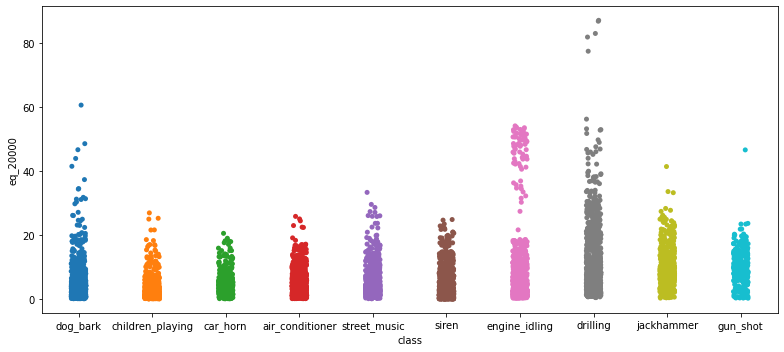

In [14]:
plt.figure(figsize=(11,5))
sns.stripplot(data = cv_features_df,
             x = 'class',
             y = 'eq_20000')
plt.tight_layout()
plt.show()

In [41]:
def TPR(prediction, data):
    """
    Returns True Positive Ratio given a prediction and data
    """
    confmat = confusion_matrix(prediction, data)

    TN = confmat[0,0]
    FP = confmat[0,1]
    FN = confmat[1,0]
    TP = confmat[1,1]
    
    return TP / (TP + FN)
    

In [ ]:
def Fmeasure(prediction, data):
    """
    Returns Fmeasure. 
    
    This is considered a balance of the precision and the recall.
    
    F = (2*P*R)/(P+R)
    
    where
    
    P = TP/(TP + FP) is the precision and
    R = TP/(TP + FN) is the recall.
    
    Reference: 
    Müller, Meinard. Fundamentals of music processing: Audio, analysis, algorithms, applications. 
    Vol. 5. Cham: Springer, 2015.
    Sec. 4.5 pp. 217
    """
    confmat = confusion_matrix(prediction, data)

    TN = confmat[0,0]
    FP = confmat[0,1]
    FN = confmat[1,0]
    TP = confmat[1,1]
    
    P = TP/(TP + FP)
    R = TP/(TP + FN)
    
    F = (2*P*R)/(P + R)
    return F
    

## Establishing a baseline: The Random Forest

In [15]:
forest = RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=4) 

In [16]:
if len(classify_keys) == 1:
    X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
else:
    X_train = cv_features_df[classify_keys].values
    
y_train = cv_features_df['class'].values

X_test = validation_features_df[classify_keys].values
y_test = validation_features_df['class']

In [17]:
set(np.where(np.isnan(X_train) == 1)[0])

set()

In [18]:
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=4)

In [19]:
pred = forest.predict(X_test)

In [20]:
accuracy_score(pred,y_test)

0.49828178694158076

In [21]:
forest.feature_importances_

array([0.03323682, 0.03214246, 0.02923297, 0.0298364 , 0.02991064,
       0.03072522, 0.03022954, 0.03111734, 0.03619993, 0.04079557,
       0.03507978, 0.03369394, 0.02918203, 0.02948576, 0.0311342 ,
       0.026871  , 0.02232775, 0.02073845, 0.02165877, 0.02476572,
       0.03142062, 0.03322886, 0.0330845 , 0.05944801, 0.02722038,
       0.05152416, 0.05564462, 0.01630938, 0.05823   , 0.03552516])

### Trying another model: A simple NN

In [22]:
mlp = MLPClassifier(alpha=0.001, max_iter=1000)

In [23]:
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.001, max_iter=1000)

In [24]:
pred_mlp = mlp.predict(X_test)

In [25]:
accuracy_score(pred_mlp,y_test)

0.46964490263459335

## Looping through specified models

In [42]:
for i, classifier in enumerate(classifiers):

    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    print(f'{names[i]} Classifier accuracy score: {accuracy_score(y_test, pred)}')
    print(f'{names[i]} Classifier TPR: {TPR(y_test, pred)}')

Nearest Neighbors Classifier accuracy score: 0.40893470790378006
Nearest Neighbors Classifier TPR: 0.7
Linear SVM Classifier accuracy score: 0.5315005727376861
Linear SVM Classifier TPR: 0.72
RBF SVM Classifier accuracy score: 0.10996563573883161
RBF SVM Classifier TPR: nan


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


Decision Tree Classifier accuracy score: 0.38717067583046966
Decision Tree Classifier TPR: 0.875
Random Forest Classifier accuracy score: 0.4936998854524628
Random Forest Classifier TPR: 0.8461538461538461
Neural Net Classifier accuracy score: 0.46048109965635736
Neural Net Classifier TPR: 0.6923076923076923
AdaBoost Classifier accuracy score: 0.34822451317296677
AdaBoost Classifier TPR: 0.8571428571428571
Naive Bayes Classifier accuracy score: 0.284077892325315
Naive Bayes Classifier TPR: 1.0
QDA Classifier accuracy score: 0.4833906071019473
QDA Classifier TPR: 0.9375
LDA Classifier accuracy score: 0.5189003436426117
LDA Classifier TPR: 0.36
ExtraTrees Classifier accuracy score: 0.43986254295532645
ExtraTrees Classifier TPR: 1.0


## Trying out a Voting Classifier to beat the others

In [43]:
voter_list = [(names[i], classifiers[i]) for i in range(len(names))]

In [44]:
voting = VotingClassifier(voter_list,
                         voting='hard')

In [45]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Nearest Neighbors',
                              KNeighborsClassifier(n_neighbors=10)),
                             ('Linear SVM', SVC(C=0.025, kernel='linear')),
                             ('RBF SVM', SVC(C=1, gamma=2)),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=15)),
                             ('Random Forest',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=500)),
                             ('Neural Net',
                              MLPClassifier(alpha=0.1, max_iter=1000)),
                             ('AdaBoost', AdaBoostClassifier()),
                             ('Naive Bayes', GaussianNB()),
                             ('QDA', QuadraticDiscriminantAnalysis()),
                             ('LDA', LinearDiscriminantAnalysis()),
                             ('ExtraTrees',
                

In [48]:
vpred = voting.predict(X_test)


In [49]:
accuracy_score(y_test,vpred)

0.5601374570446735

In [50]:
TPR(y_test,vpred)

0.8461538461538461

## Considering all folds in validation

In [56]:
accuracies = np.zeros((len(names),11))
TPRs = np.zeros((len(names),11))

In [57]:
for dropfold in range(1,11):

    cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
    validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)

    if len(classify_keys) == 1:
        X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
    else:
        X_train = cv_features_df[classify_keys].values

    y_train = cv_features_df['class'].values

    X_test = validation_features_df[classify_keys].values
    y_test = validation_features_df['class']

    for i, classifier in enumerate(classifiers):
        print(dropfold, i)
        classifier.fit(X_train, y_train)
        pred = classifier.predict(X_test)
        
        accuracies[dropfold][i] = accuracy_score(y_test, pred)
        TPRs[dropfold][i] = TPR(y_test, pred)
        
        #print(f'{names[i]} Classifier accuracy score: {accuracy_score(y_test, pred)}')
        #print(f'{names[i]} Classifier TPR: {TPR(y_test, pred)}')

1 0
1 1
1 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 0
2 1
2 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 0
3 1
3 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 0
4 1
4 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 0
5 1
5 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 0
6 1
6 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 0
7 1
7 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 0
8 1
8 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 0
9 1
9 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 0
10 1
10 2


<ipython-input-41-9dad0e52d676>:9: RuntimeWarning: invalid value encountered in long_scalars
  return TP/ (TP+FN)


10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10


In [71]:
TPRs_final = np.mean(TPRs[1:],axis=0)
accuracies_final = np.mean(accuracies[1:],axis=0)

In [73]:
for i,name in enumerate(names):
    print(f'{name} accuracy: {accuracies_final[i]}')

Nearest Neighbors accuracy: 0.3781269830513282
Linear SVM accuracy: 0.5198426335102768
RBF SVM accuracy: 0.10146429853125286
Decision Tree accuracy: 0.4130136377174594
Random Forest accuracy: 0.5389667933141233
Neural Net accuracy: 0.5076092248413605
AdaBoost accuracy: 0.38351916605531977
Naive Bayes accuracy: 0.28576385159200074
QDA accuracy: 0.4546373429373478
LDA accuracy: 0.45704257917958024
ExtraTrees accuracy: 0.47797665150361823


In [74]:
for i,name in enumerate(names):
    print(f'{name} TPR: {TPRs_final[i]}')

Nearest Neighbors TPR: 0.49146367984335626
Linear SVM TPR: 0.6217840738022912
RBF SVM TPR: nan
Decision Tree TPR: 0.79232468343016
Random Forest TPR: 0.8499818735802718
Neural Net TPR: 0.7566500166500166
AdaBoost TPR: 0.7429820875718709
Naive Bayes TPR: 0.7343223443223442
QDA TPR: 0.7985885138593216
LDA TPR: 0.49020268666836164
ExtraTrees TPR: 0.6901424233661075
